#### Plotting and save weights functions

In [4]:
import matplotlib.pyplot as plt
import torch

def plot_training_validation_metrics(train_losses, val_losses, train_accuracies, val_accuracies, filename):
    # Plot training and validation loss
    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label='Training Loss', color='skyblue')
    plt.plot(val_losses, label='Validation Loss', color='salmon')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{filename}_loss.png")

    # Plot training and validation accuracy
    plt.figure(figsize=(12, 6))
    plt.plot(train_accuracies, label='Training Accuracy', color='skyblue')
    plt.plot(val_accuracies, label='Validation Accuracy', color='salmon')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{filename}_accuracy.png")


# Saving our model weights
def save_model_weights(model, filename):
    torch.save(model.state_dict(), filename)
    print(f"Model weights saved to {filename}")

#### Prepare HMDB51 dataset

In [3]:
import glob
from collections import Counter
import os

keep_hmdb51 = ["clap", "climb", "drink", "jump", "pour", "ride_bike", "ride_horse", 
        "run", "shoot_bow", "smoke", "throw", "wave"]

TRAIN_TAG, TEST_TAG = 1, 2
full_train_files, test_files = [], []
full_train_labels, test_labels = [], []
split_pattern_name = f"*test_split1.txt"
split_pattern_path = os.path.join('HMDB51\\test_train_splits', split_pattern_name)
annotation_paths = glob.glob(split_pattern_path)

for filepath in annotation_paths:

    base_name = os.path.basename(filepath)
    class_name = '_'.join(base_name.split('_')[:-2])

    # Doesn't work with the original code given
    # class_name = '_'.join(filepath.split('/')[-1].split('_')[:-2])

    if class_name not in keep_hmdb51:
        continue  # skipping the classes that we won't use.
    with open(filepath) as fid:
        lines = fid.readlines()
    for line in lines:
        video_filename, tag_string = line.split()
        tag = int(tag_string)
        if tag == TRAIN_TAG:
            full_train_files.append(video_filename)
            full_train_labels.append(class_name)
        elif tag == TEST_TAG:
            test_files.append(video_filename)
            test_labels.append(class_name)

print(f'Train files ({len(full_train_files)}):\n\t{full_train_files}')
print(f'Train labels ({len(full_train_labels)}):\n\t{full_train_labels}\n'\
      f'Train Distribution:{list(Counter(sorted(full_train_labels)).items())}\n')
print(f'Test files ({len(test_files)}):\n\t{test_files}')
print(f'Test labels ({len(test_labels)}):\n\t{test_labels}\n'\
      f'Test Distribution:{list(Counter(sorted(test_labels)).items())}\n')
action_categories = sorted(list(set(full_train_labels)))
print(f'Action categories ({len(action_categories)}):\n{action_categories}')


# Split the training data into training 90% and validation 10%

import random

# Keep the files and labels pairing
combined = list(zip(full_train_files, full_train_labels))
random.shuffle(combined)
shuffled_train_files, shuffled_train_labels = zip(*combined)

# Validation is 10%
val_size = int(0.1 * len(shuffled_train_files))

val_files = shuffled_train_files[:val_size]
val_labels = shuffled_train_labels[:val_size]
train_files = shuffled_train_files[val_size:]
train_labels = shuffled_train_labels[val_size:]

print(f'Train files ({len(train_files)}):\n\t{train_files}')
print(f'Train labels ({len(train_labels)}):\n\t{train_labels}\n'\
      f'Train Distribution:{list(Counter(sorted(train_labels)).items())}\n')

print(f'Validation files ({len(val_files)}):\n\t{val_files}')
print(f'Validation labels ({len(val_labels)}):\n\t{val_labels}\n'\
      f'Validation Distribution:{list(Counter(sorted(val_labels)).items())}\n')

Train files (840):
	['#20_Rhythm_clap_u_nm_np1_fr_goo_0.avi', '#20_Rhythm_clap_u_nm_np1_fr_goo_1.avi', '#20_Rhythm_clap_u_nm_np1_fr_goo_2.avi', '#20_Rhythm_clap_u_nm_np1_le_goo_3.avi', '#20_Rhythm_clap_u_nm_np1_le_goo_4.avi', 'A_Round_of_Applause_clap_u_cm_np1_fr_med_0.avi', 'A_Round_of_Applause_clap_u_cm_np1_fr_med_1.avi', 'Applauding_Abby_clap_u_nm_np1_fr_med_0.avi', 'Applauding_Abby_clap_u_nm_np1_fr_med_1.avi', 'Baby_Bob_kann_klatschen_!_clap_u_cm_np1_fr_med_0.avi', 'Baby_Bob_kann_klatschen_!_clap_u_cm_np1_fr_med_1.avi', 'Baby_Bob_kann_klatschen_!_clap_u_cm_np1_fr_med_2.avi', 'Boom_Snap_Clap_clap_u_nm_np1_fr_med_0.avi', 'Boom_Snap_Clap_clap_u_nm_np1_fr_med_1.avi', 'Boom__Snap__Clap!_(Challenge)_clap_u_nm_np1_fr_med_1.avi', 'Budam_-_Clap_Hands_clap_u_nm_np1_fr_med_0.avi', 'Budam_-_Clap_Hands_clap_u_nm_np1_fr_med_1.avi', 'Budam_-_Clap_Hands_clap_u_nm_np1_fr_med_2.avi', 'Clap_Hands_clap_u_nm_np1_fr_med_0.avi', 'Clap_Hands_clap_u_nm_np1_fr_med_1.avi', 'Clap_Hands_clap_u_nm_np1_fr_med_2.

#### Defining the 2 CNN Streams (models) - No fusion model yet

In [5]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import cv2
import os
import torch.nn as nn

# Use gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the path to the 'video_data' folder
video_folder = 'HMDB51/video_data'

# Define the data transforms
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create custom dataset for HMDB51
class HMDB51Dataset(Dataset):
    def __init__(self, file_list, labels, video_folder, transform=None):
        self.file_list = file_list
        self.labels = [action_categories.index(label) for label in labels]  # Convert labels to integers
        self.video_folder = video_folder
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        video_name = self.file_list[index]
        label = self.labels[index]
        class_name = action_categories[label]
        video_path = os.path.join(self.video_folder, class_name, video_name)
        video = cv2.VideoCapture(video_path)
        frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
        middle_frame_idx = frame_count // 2
        video.set(cv2.CAP_PROP_POS_FRAMES, middle_frame_idx)
        ret, frame = video.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = Image.fromarray(frame)
            if self.transform:
                frame = self.transform(frame)
        else:
            raise ValueError(f"Failed to read middle frame from video: {video_path}")
        return frame, label

# Create data loaders for HMDB51
train_dataset_f = HMDB51Dataset(train_files, train_labels, video_folder, transform=data_transforms)
val_dataset_f = HMDB51Dataset(val_files, val_labels, video_folder, transform=data_transforms)
test_dataset_f = HMDB51Dataset(test_files, test_labels, video_folder, transform=data_transforms)

train_loader_f = DataLoader(train_dataset_f, batch_size=32, shuffle=True)
val_loader_f = DataLoader(val_dataset_f, batch_size=32, shuffle=False)
test_loader_f = DataLoader(test_dataset_f, batch_size=32, shuffle=False)

# Define the custom CNN architecture
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        # Flattening the tensor
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x
    
# Load the pretrained model
pretrained_model_f = CustomCNN(num_classes=len(action_categories))
pretrained_model_f.load_state_dict(torch.load('HMDB51-Frames.pth'))
pretrained_model_f = pretrained_model_f.to(device)


In [6]:
label_to_index = {
    "clap": 0,
    "climb": 1,
    "drink": 2,
    "jump": 3,
    "pour": 4,
    "ride_bike": 5,
    "ride_horse": 6,
    "run": 7,
    "shoot_bow": 8,
    "smoke": 9,
    "throw": 10,
    "wave": 11
}

class OpticalFlowDataset(Dataset):
    def __init__(self, data_directory, file_names, labels, transforms=None):
        # directory of the classes folders
        self.data_directory = data_directory
        # train files or validation files
        self.file_names = file_names
        self.labels = labels
        self.transforms = transforms
        self.samples = self._prepare_dataset()
        
    def _prepare_dataset(self):
        samples = []
        for video_name, label in zip(self.file_names, self.labels):
            # remove .avi from video name to use for directory
            video_name = os.path.splitext(video_name)[0]

            # label is the class folder name
            class_folder = label
            flow_images_path = os.path.join(self.data_directory, 'optical_flow', class_folder, video_name)
            # We have 16 optical flow images
            flow_image_files = []
            for i in range(0, 16):  
                flow_image_path = os.path.join(flow_images_path, f'{video_name}_flow_{i:04d}.png')
                flow_image_files.append((flow_image_path, label))
            samples.append(flow_image_files)
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        flow_image_paths, labels = zip(*sample)

        flow_images = [Image.open(file_path) for file_path in flow_image_paths]
        if self.transforms:
            flow_images = [self.transforms(flow_image) for flow_image in flow_images]
        # Stacking is wrong cause we get a 5D tensor, I think we need to concatenate
        flow_images_concatenated = torch.cat(flow_images, axis=0)
        # All 16 frames have the same label
        label = labels[0]
        # Apparently for the loss function we need to make the string label to a numerical value and then to a tensor
        label_index = label_to_index[label]
        # label_tensor = torch.tensor(label_index, dtype=torch.long)

        return flow_images_concatenated, label_index
    
# Instantiate your dataset
train_dataset_of = OpticalFlowDataset(
    data_directory='HMDB51',
    file_names=train_files,
    labels=train_labels,
    transforms=data_transforms
)

val_dataset_of = OpticalFlowDataset(
    data_directory='HMDB51',
    file_names=val_files,
    labels=val_labels,
    transforms=data_transforms
)

test_dataset_of = OpticalFlowDataset(
    data_directory='HMDB51',
    file_names= test_files, 
    labels = test_labels,
    transforms=data_transforms)

train_loader_of = DataLoader(train_dataset_of, batch_size=32, shuffle=True)
val_loader_of = DataLoader(val_dataset_of, batch_size=32, shuffle=False)
test_loader_of = DataLoader(test_dataset_of, batch_size=32, shuffle=False)


class OpticalFlowCNN(nn.Module):
    def __init__(self, num_classes=12):
        super(OpticalFlowCNN, self).__init__()

        # Input 48 because we got 16 frames and 3 channels each
        self.conv1 = nn.Conv2d(48, 64, kernel_size=3, stride=2, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.relu4 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(256 * 14 * 14, 1024)
        self.relu_fc1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu4(self.conv4(self.relu3(self.conv3(x)))))
        
        x = self.flatten(x)
        
        x = self.dropout1(self.relu_fc1(self.fc1(x)))
        x = self.fc2(x)
        
        return x

# Load the pretrained model
pretrained_model_of = OpticalFlowCNN(num_classes=len(action_categories))
pretrained_model_of.load_state_dict(torch.load('HMDB51-OpticalFlow.pth'))
pretrained_model_of = pretrained_model_of.to(device)

#### Fusion of the models

In [7]:
class TwoStreamModel(nn.Module):
    def __init__(self, num_classes, frame_model, flow_model):
        super(TwoStreamModel, self).__init__()
        self.frame_model = frame_model
        self.flow_model = flow_model
        
        # Remove the last fully connected layer from both streams
        self.frame_model.fc2 = nn.Identity()
        self.flow_model.fc2 = nn.Identity()

        # # Add 1x1 convolutions to connect activations between the two branches
        # self.frame_conv = nn.Conv2d(512, 10, kernel_size=1)
        # self.flow_conv = nn.Conv2d(1024, 10, kernel_size=1)
        
        # # Add a new fully connected layer for fusion
        # self.fc = nn.Linear(20, num_classes)

        # Need to add more layers after fusion
        # Add a new fully connected layer for fusion
        self.fc = nn.Linear(128 + 1024, num_classes)

    def forward(self, x_frame, x_flow):
        x_frame = self.frame_model(x_frame)
        x_flow = self.flow_model(x_flow)

        # # Apply 1x1 convolutions to the activations
        # x_frame = self.frame_conv(x_frame)
        # x_flow = self.flow_conv(x_flow)

        # Fusion here, unsure yet
        # Concatenate the two outputs
        x = torch.cat((x_frame, x_flow), dim=1)

        # Add more layers here
        x = self.fc(x)

        return x
    
two_stream_model = TwoStreamModel(num_classes = len(action_categories), frame_model = pretrained_model_f, flow_model = pretrained_model_of)
two_stream_model = two_stream_model.to(device)

class TwoStreamDataset(Dataset):
    def __init__(self, frame_dataset, flow_dataset):
        self.frame_dataset = frame_dataset
        self.flow_dataset = flow_dataset

    def __len__(self):
        # Irrelevant
        return len(self.frame_dataset)

    def __getitem__(self, index):
        frame, label = self.frame_dataset[index]
        flow, _ = self.flow_dataset[index]
        return frame, flow, label


train_dataset_twostream = TwoStreamDataset(train_dataset_f, train_dataset_of)
val_dataset_twostream = TwoStreamDataset(val_dataset_f, val_dataset_of)
test_dataset_twostream = TwoStreamDataset(test_dataset_f, test_dataset_of)

train_loader_twostream = DataLoader(train_dataset_twostream, batch_size=32, shuffle=True)
val_loader_twostream = DataLoader(val_dataset_twostream, batch_size=32, shuffle=False)
test_loader_twostream = DataLoader(test_dataset_twostream, batch_size=32, shuffle=False)

Epoch 1/10, Train Loss: 2.6262, Train Accuracy: 0.1720, Validation Loss: 1.9768, Validation Accuracy: 0.3810
Epoch 2/10, Train Loss: 1.6197, Train Accuracy: 0.4934, Validation Loss: 1.2968, Validation Accuracy: 0.5952
Epoch 3/10, Train Loss: 0.7481, Train Accuracy: 0.7632, Validation Loss: 1.1888, Validation Accuracy: 0.6190
Epoch 4/10, Train Loss: 0.2642, Train Accuracy: 0.9325, Validation Loss: 0.9862, Validation Accuracy: 0.7500
Epoch 5/10, Train Loss: 0.0744, Train Accuracy: 0.9775, Validation Loss: 1.1746, Validation Accuracy: 0.6667
Epoch 6/10, Train Loss: 0.1306, Train Accuracy: 0.9841, Validation Loss: 1.7104, Validation Accuracy: 0.6071
Epoch 7/10, Train Loss: 0.0507, Train Accuracy: 0.9907, Validation Loss: 1.1464, Validation Accuracy: 0.6905
Epoch 8/10, Train Loss: 0.0941, Train Accuracy: 0.9907, Validation Loss: 1.4762, Validation Accuracy: 0.6190
Epoch 9/10, Train Loss: 0.1444, Train Accuracy: 0.9881, Validation Loss: 1.4921, Validation Accuracy: 0.6548
Epoch 10/10, Train 

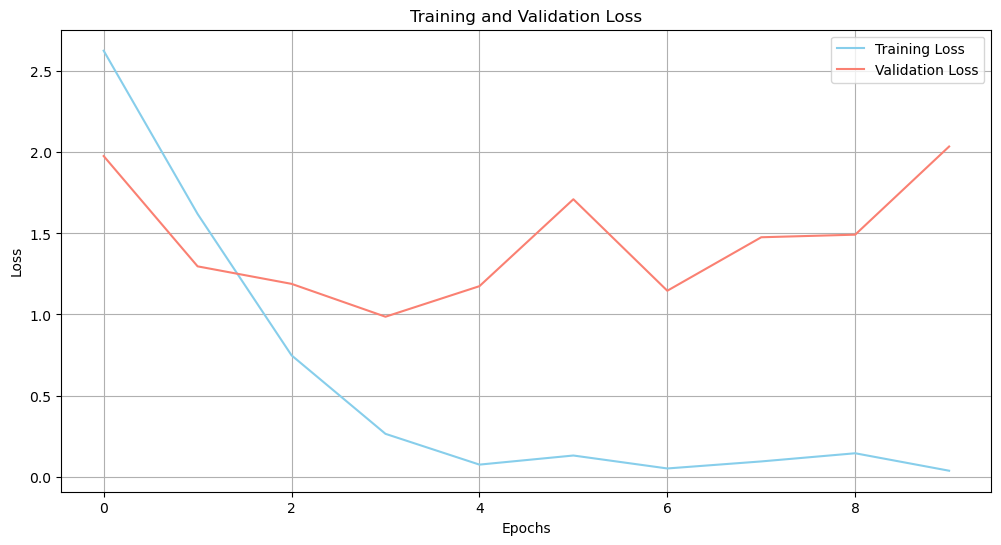

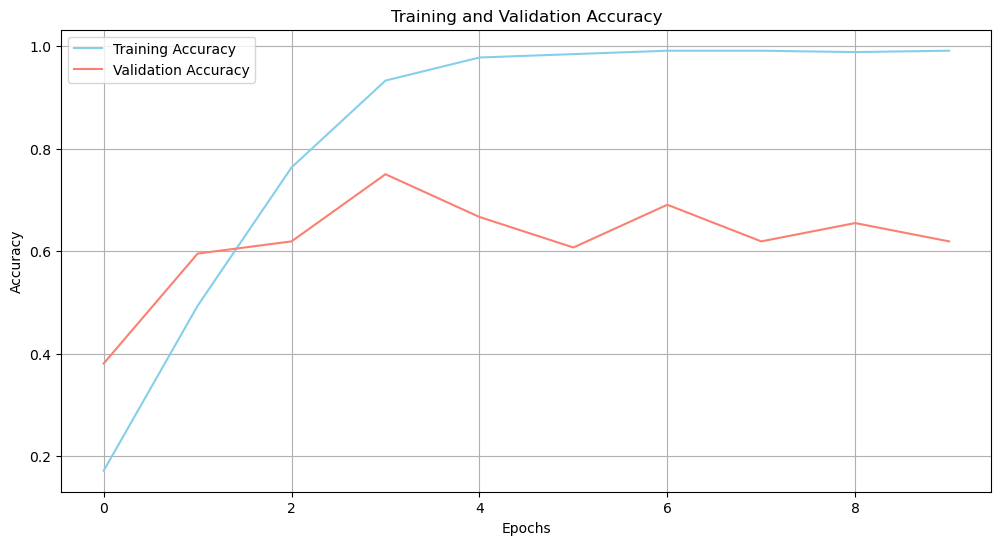

In [8]:
# Training and Validation

from torch.optim import Adam
from torch.nn import CrossEntropyLoss

num_epochs = 10

loss_function = CrossEntropyLoss().to(device)
optimizer = Adam(two_stream_model.parameters(), lr=0.001)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    two_stream_model.train()
    running_loss, running_corrects = 0.0, 0
    
    for frame_inputs, flow_inputs, labels in train_loader_twostream:
        frame_inputs, flow_inputs, labels = frame_inputs.to(device), flow_inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = two_stream_model(frame_inputs, flow_inputs)
        loss = loss_function(outputs, labels)
        _, preds = torch.max(outputs, 1)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * frame_inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / len(train_loader_twostream.dataset)
    epoch_acc = running_corrects.double() / len(train_loader_twostream.dataset)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc.item())
    
    two_stream_model.eval()
    running_val_loss, running_val_corrects = 0.0, 0
    
    with torch.no_grad():
        for frame_inputs, flow_inputs, labels in val_loader_twostream:
            frame_inputs, flow_inputs, labels = frame_inputs.to(device), flow_inputs.to(device), labels.to(device)
            outputs = two_stream_model(frame_inputs, flow_inputs)
            loss = loss_function(outputs, labels)
            _, preds = torch.max(outputs, 1)
            running_val_loss += loss.item() * frame_inputs.size(0)
            running_val_corrects += torch.sum(preds == labels.data)
    
    epoch_val_loss = running_val_loss / len(val_loader_twostream.dataset)
    epoch_val_acc = running_val_corrects.double() / len(val_loader_twostream.dataset)
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc.item())
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}, Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_acc:.4f}')

# Plotting training and validation metrics
plot_training_validation_metrics(train_losses, val_losses, train_accuracies, val_accuracies, 'HMDB51-TwoStream')
save_model_weights(two_stream_model, 'HMDB51-TwoStream.pth')

In [9]:
# Testing the model

two_stream_model.eval()
running_test_corrects = 0

with torch.no_grad():
    for frame_inputs, flow_inputs, labels in test_loader_twostream:
        frame_inputs, flow_inputs, labels = frame_inputs.to(device), flow_inputs.to(device), labels.to(device)
        outputs = two_stream_model(frame_inputs, flow_inputs)
        _, preds = torch.max(outputs, 1)
        running_test_corrects += torch.sum(preds == labels.data)

test_acc = running_test_corrects.double() / len(test_loader_twostream.dataset)
print(f'Test Accuracy: {test_acc:.4f}')
